# **Segmentez des clients d'un site e-commerce**

**Etude de stabilité**

In [ ]:
pip install numpy pandas scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msn
import seaborn as sns
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer, IterativeImputer
from sklearn.linear_model import LinearRegression

In [ ]:
# Afficher toutes les colonnes
pd.options.display.max_columns = None

In [ ]:
data_orders = pd.read_csv('orders.csv')
data_order_items = pd.read_csv('order_items.csv')
data_order_pymts = pd.read_csv('order_pymts.csv')
data_geoloc = pd.read_csv('geoloc.csv')
data_order_reviews = pd.read_csv('order_reviews.csv')
data_sellers = pd.read_csv('sellers.csv')
data_translation = pd.read_csv('translation.csv')
data_products = pd.read_csv('products.csv')
data_customers = pd.read_csv('customers.csv')


*Creation du fichier client*

# **Etude de la stabilité temporaire**

Avec l'arrivée de nouveaux clients, nous envisageons de les assigner à des clusters existants en utilisant la méthode K-means.predict. Cette méthode attribue à chaque nouveau client le cluster correspondant au centroïde le plus proche.

Cela nous permet de prédire à quel cluster un nouveau client appartiendra. Cependant, à un certain point, on peut se demander si, en ré-entraînant le modèle de clustering avec les nouveaux clients, nous obtiendrons les mêmes clusters que ceux initiaux. Pour vérifier cela, il sera nécessaire de mesurer l'impact des nouveaux clients sur les clusters initiaux.

Nous allons procéder à une simulation. Par exemple, de ('2016-10-13 16:03:06') à 2018-01-01, nous considérons les clusters initiaux et, après l'arrivée de nouveaux clients chaque une semaine, nous les assignons au centroïde le plus proche des clusters initiaux. Ensuite, nous ré-entraînons le modèle K-means avec les nouveaux clients et calculons l'indice ARI (Adjusted Rand Index) pour vérifier si les clusters se superposent bien avec ceux d'origine.

Nous répéterons ce processus  8 fois afin d'observer l'évolution de l'ARI. L'objectif est de déterminer à quelle fréquence l'entreprise devrait ré-entraîner son modèle de clustering afin de maintenir sa pertinence.

In [ ]:
import sqlite3
import pandas as pd

# Connexion à la base de données
conn = sqlite3.connect('olist.db')

# Définition de la requête SQL avec les nouveaux noms de colonnes
query = """
WITH
    Frequence AS (
        SELECT
            c.customer_unique_id,
            COUNT(DISTINCT o.order_id) AS frequence
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    Montant AS (
        SELECT
            c.customer_unique_id,
            SUM(oi.price) AS total_amount_spent
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        JOIN order_items oi ON o.order_id = oi.order_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    ScoreReview AS (
        SELECT
            c.customer_unique_id,
            AVG(r.review_score) AS average_review_score
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        JOIN order_reviews r ON o.order_id = r.order_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    LastOrder AS (
        SELECT
            c.customer_unique_id,
            MAX(o.order_delivered_customer_date) AS last_order_date,
            DATE('now') - MAX(o.order_delivered_customer_date) AS days_since_last_order,
            MIN(o.order_purchase_timestamp) AS first_order_date
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    OrderValues AS (
        SELECT
            c.customer_unique_id,
            AVG(oi.price) AS average_order_value,
            MAX(oi.price) AS max_order_value,
            AVG(oi.freight_value) AS average_freight_value
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        JOIN order_items oi ON o.order_id = oi.order_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    PaymentTypes AS (
        SELECT
            c.customer_unique_id,
            p.payment_type,
            COUNT(p.payment_type) AS payment_count
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        JOIN order_pymts p ON o.order_id = p.order_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id, p.payment_type
    ),
    FrequentPaymentType AS (
        SELECT
            customer_unique_id,
            payment_type,
            payment_count,
            RANK() OVER (PARTITION BY customer_unique_id ORDER BY payment_count DESC) AS payment_rank
        FROM PaymentTypes
    )
SELECT
    f.customer_unique_id,
    f.frequence,
    m.total_amount_spent,  -- Total des montants dépensés
    sr.average_review_score,  -- Score de revue moyen
    lo.days_since_last_order,
    lo.first_order_date,
    ov.average_order_value,
    ov.max_order_value,
    ov.average_freight_value,
    ftp.payment_type AS most_frequent_payment_type
FROM Frequence f
JOIN Montant m ON f.customer_unique_id = m.customer_unique_id
JOIN ScoreReview sr ON f.customer_unique_id = sr.customer_unique_id
JOIN LastOrder lo ON f.customer_unique_id = lo.customer_unique_id
JOIN OrderValues ov ON f.customer_unique_id = ov.customer_unique_id
LEFT JOIN FrequentPaymentType ftp ON f.customer_unique_id = ftp.customer_unique_id AND ftp.payment_rank = 1;
"""

# Exécution de la requête et récupération des données dans un DataFrame
data_fichier_clients = pd.read_sql_query(query, conn)

# Afficher les résultats
display(data_fichier_clients)

# Fermer la connexion
conn.close()


,customer_unique_id,frequence,total_amount_spent,average_review_score,days_since_last_order,first_order_date,average_order_value,max_order_value,average_freight_value,most_frequent_payment_type
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,5.0,6,2018-05-10 10:56:27,129.90,129.90,12.00,credit_card
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,4.0,6,2018-05-07 11:11:27,18.90,18.90,8.29,credit_card
2,0000f46a3911fa3c0805444483337064,1,69.00,3.0,7,2017-03-10 21:05:03,69.00,69.00,17.22,credit_card
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,4.0,7,2017-10-12 20:29:41,25.99,25.99,17.63,credit_card
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,5.0,7,2017-11-14 19:45:42,180.00,180.00,16.89,credit_card
...,...,...,...,...,...,...,...,...,...,...
94712,fffcf5a5ff07b0908bd4e2dbc735a684,1,1570.00,5.0,7,2017-06-08 21:00:36,785.00,890.00,248.71,credit_card
94713,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,4.0,6,2017-12-10 20:07:56,64.89,64.89,19.69,credit_card
94714,ffff371b4d645b6ecea244b27531430a,1,89.90,5.0,7,2017-02-07 15:49:16,89.90,89.90,22.56,credit_card
94715,ffff5962728ec6157033ef9805bacc48,1,115.00,5.0,6,2018-05-02 15:17:41,115.00,115.00,18.69,credit_card


In [ ]:
# Vérification des doublons
print(data_fichier_clients.duplicated().sum())

0


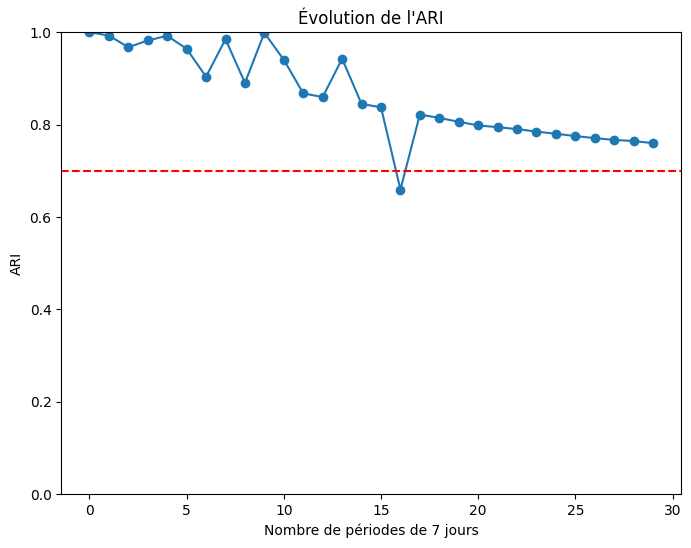

In [ ]:


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score

# Conversion de la colonne 'first_order_date' en format datetime
data_fichier_clients['first_order_date'] = pd.to_datetime(data_fichier_clients['first_order_date'], errors='coerce')


# Dates de référence
date_min = pd.to_datetime('2016-10-13')
date_ref = pd.to_datetime('2018-01-01')
nb_semaines = 30


# Filtrer les clients jusqu'au 1er janvier 2018
filter_initial = (data_fichier_clients['first_order_date'] >= date_min) & (data_fichier_clients['first_order_date'] <= date_ref)
data_initial = data_fichier_clients[filter_initial].copy()

# Caractéristiques pour clustering

# Définition de la liste des features
features = ['days_since_last_order', 'total_amount_spent',
                       'average_order_value', 'max_order_value', 'average_freight_value',
                        'average_review_score']

# Prétraitement des données (normalisation)
X_initial = data_initial[features].copy()
scaler_initial = MinMaxScaler()
X_initial_scaled = scaler_initial.fit_transform(X_initial)

# Clustering initial avec K-Means
km_initial = KMeans(n_clusters=6, random_state=42)
km_initial.fit(X_initial_scaled)

ARI_list = []

# Boucle pour ajouter de nouveaux clients par périodes de 7 jours, réentrainement, et calcul d'ARI
for i in range(0, nb_semaines):  # itérer sur 8 périodes de 7 jours
    date_next = date_ref + i * pd.Timedelta(days=7)
    filter_next_clients = (data_fichier_clients['first_order_date'] > date_min) & (data_fichier_clients['first_order_date'] <= date_next)
    data_next_clients = data_fichier_clients[filter_next_clients].copy()

    # avec le initial
    X_next = data_next_clients[features].copy()
    X_next_scaled = scaler_initial.transform(X_next)
    labels1 = km_initial.predict(X_next_scaled)

    # avec le nouvel entrainé
    X_next = data_next_clients[features].copy()
    scaler_retrain = MinMaxScaler()
    X_next_scaled = scaler_retrain.fit_transform(X_next)
    km_retrain = KMeans(n_clusters=6, random_state=42)
    km_retrain.fit(X_next_scaled)
    labels2 = km_retrain.predict(X_next_scaled)

    # Calcul de l'ARI pour chaque période
    ARI_score = adjusted_rand_score(labels1, labels2)
    ARI_list.append(ARI_score)

# Visualisation de l'évolution de l'ARI
plt.figure(figsize=(8, 6))
plt.plot(range(0, nb_semaines), ARI_list, marker='o')
plt.axhline(y=0.7, color='r', linestyle='--', label='Seuil ARI = 0.9')  # Ajouter une ligne de seuil à 0.5
plt.title('Évolution de l\'ARI')
plt.xlabel('Nombre de périodes de 7 jours')
plt.ylabel('ARI')
plt.ylim(0, 1)
plt.show()


